In [1]:
%matplotlib inline
import sys, os, glob, copy

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

import scienceplots

plt.style.use(['bright', 'science', 'no-latex', 'notebook'])

In [6]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')
data_agn_compare = ascii.read('hsc_agn_compare.txt')

plot the table in a skymap

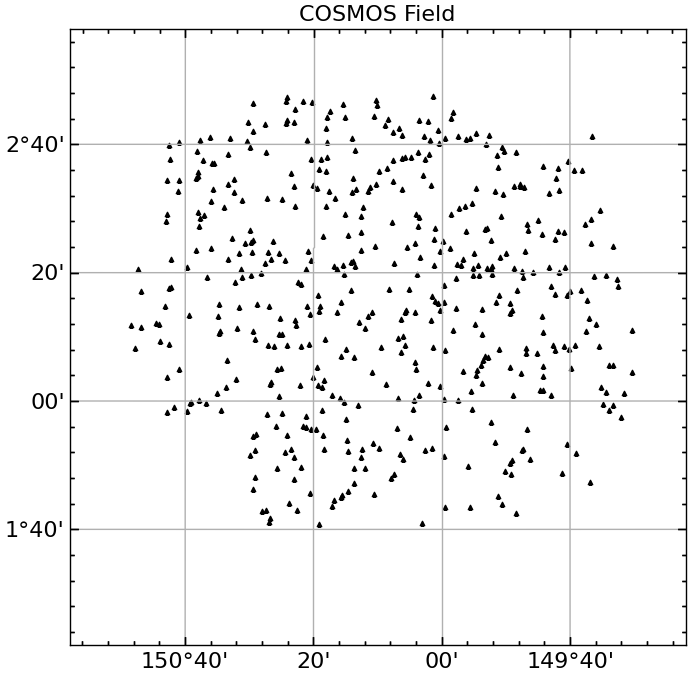

In [4]:
import ligo.skymap.plot

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='DES')

ax1.grid()
# ax1.set_ax
# ax1.coords['ra'].set_ticks_v
# ax1.coords['dec'].set_ticks_v
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)

ax1.set_title('COSMOS Field')

plt.show()

In [5]:
result_rvz_bib = data_agn_updated['bibcode']
bib, cnt = np.unique(result_rvz_bib, return_counts=True)
table.Table([bib, cnt], names=['bibcode', 'count'])

bibcode,count
str19,int64
-------------------,99
2009ApJ...696.1195T,23
2015ApJS..220...12S,3
2018ApJ...858...77H,40
2018ApJ...869...20B,2
2018ApJS..234...21D,1
2018ApJS..239...27S,3
2018PASJ...70S..10O,1
2019ApJ...877...81M,1


### Dataset overview

The spectra come from the following sources

```
------------------- 99
2009ApJ...696.1195T 23, Magellean/zCOSMOS, https://irsa.ipac.caltech.edu/data/COSMOS/
2015ApJS..220...12S 3
2018ApJ...858...77H 40, DEIMOS, not publicly available
2018ApJ...869...20B 2
2018ApJS..234...21D 1
2018ApJS..239...27S 3
2018PASJ...70S..10O 1
2019ApJ...877...81M 1
2020AJ....160...37M 1
2020ApJ...894...24K 316, HSC, a collection of specz but its sources may be available
2021ApJS..256....9S 1
```

where HSC data is compiled from the following sources: 

```
2013ApJ...767..118C, PRIMUS, only z-value is presented
```

Note: 

* "`-------------------`" means photo-z
* `2020ApJ...894...24K` and `2018ApJ...858...77H` refers to original catalogs


In [ ]:
# Charlotte has already done SDSS - nice!

# Will add the other ones (XMM-spec, Caltech COSMOS Magellen etc,)

## Magellean (incomplete)

inquiry website: https://irsa.ipac.caltech.edu/data/COSMOS/

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.57291667, 2.38752778)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.7202, 2.248003)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.72016667, 2.248)>)

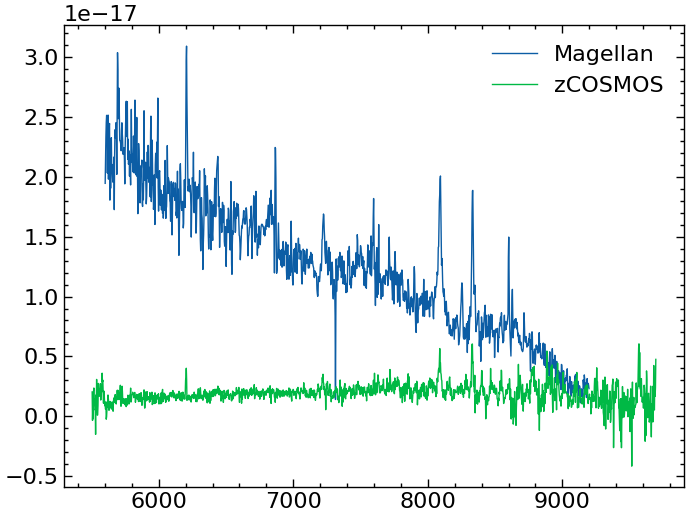

In [ ]:
# SDSS J100252.84+021452.8 

hdu1 = fits.open('spec/magellan_opt_100252+021452_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000821837_ZCMRa95_M1_Q2_16_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+' '+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+' '+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 

(<SkyCoord (ICRS): (ra, dec) in deg
     (150.22791667, 1.67563889)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.612274, 1.99442)>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (150.61225, 1.99447222)>)

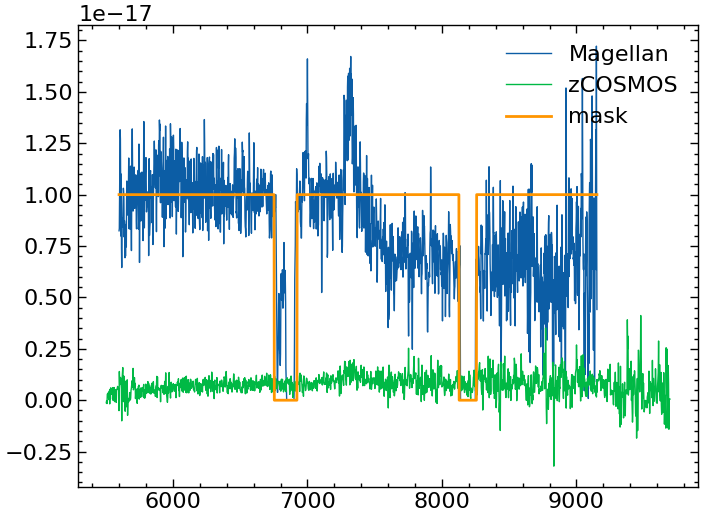

In [ ]:
# ACS-GC 20054857

hdu1 = fits.open('spec/magellan_opt_100226+015940_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

hdu2 = fits.open('spec/zCOSMOS_BRIGHT_DR3_000815962_ZCMRa83_M2_Q2_22_1.fits')
data2 = hdu2[1].data
plt.plot(data2['WAVE'][0], data2['FLUX_REDUCED'][0], label='zCOSMOS', linewidth=1)


plt.plot(data1[0], data1[3]*1e-17, label='mask')

plt.legend()

hdu1[0].header['DATE-OBS'], hdu2[0].header['DATE-OBS']

SkyCoord(hdu1[0].header['RA']+' '+hdu1[0].header['DEC'], unit=(u.hourangle, u.deg)), \
SkyCoord(str(hdu2[0].header['RA'])+' '+str(hdu2[0].header['DEC']), unit=(u.deg, u.deg)), \
SkyCoord('10h 02m 26.94s +01d 59m 40.1s')
# SkyCoord('10:02:52.84 +02:14:52.8', unit=(u.hourangle, u.deg)), 



template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

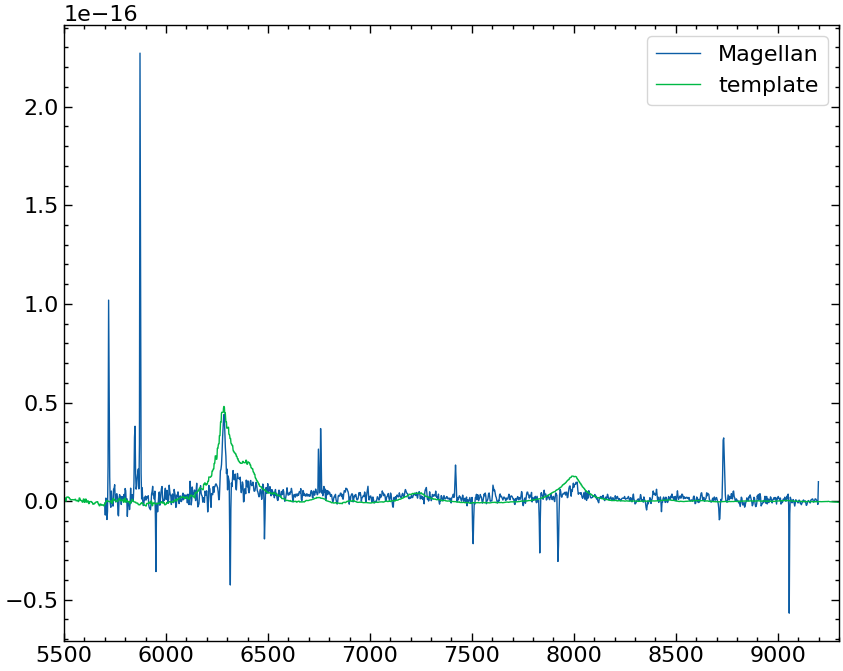

In [ ]:
# COSMOS 2042408 (300)

plt.figure(figsize=[10, 8])

hdu1 = fits.open('spec/magellan_opt_095906+022639_spec_31.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1)

wl_HB = 4861
wl_MgII = 2798
wl_CIV = 1549
# z = 0.276
# plt.axvline(x=wl_HB*(1+z), c='C1', linewidth=1, label='H Beta (HSC z)')
z = 4.17
# plt.axvline(x=wl_CIV*(1+z), c='C2', linewidth=1, label='C IV (Magellan z)')

hdutemp = fits.open('spec/spDR2-029.fit')
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17/5, label='template', linewidth=1)

plt.xlim(5500, 9300)
plt.legend(frameon=True)


In [ ]:
# COSMOS2015 382203 (52)



## HSC (incomplete)

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/specz-2/

### Grab the HSC data and see what database it comes from

We first download all the spectra in cosmos field and then filter them using python. HSC catalog uses `SQL` to inquire about the redshift, which is not suitable for mass and fuzzy inquiry. 

```sql

SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift
      , specz_duplicationflag

      , specz_flag_zcosmos_bright_dr3
      , specz_flag_3dhst_v4_1_5
      , specz_flag_sdss_dr15
      , specz_flag_gama_dr3
      , specz_flag_udsz_dr1
      , specz_flag_vandels_dr2
      , specz_flag_c3r2_dr2
      , specz_flag_vvds_drfinal
      , specz_flag_deimos_2018
      , specz_flag_fmos_dr2
      , specz_flag_lega_c_dr2
      , specz_flag_primus_dr1
      , specz_flag_vipers_dr2
      , specz_flag_wigglez_dr1
      , specz_flag_deep23_dr4_egs

    FROM pdr3_dud_rev.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;

```

It will return a `csv` file that contains all the phot-z in COSMIS field. 

Then, we match our catalog to csv that contains its source. 

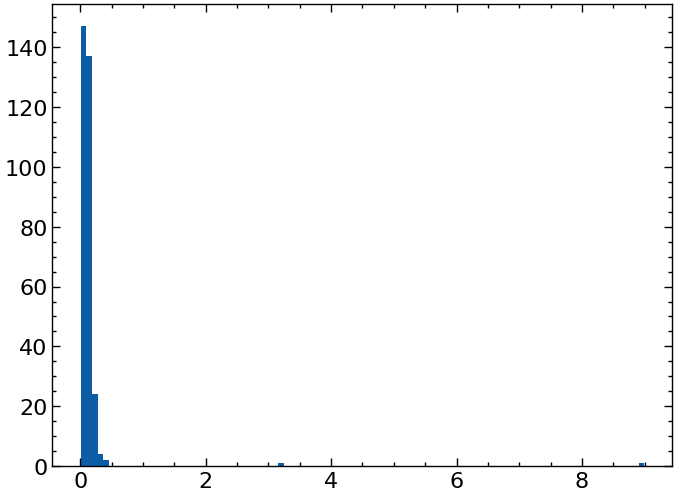

In [51]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

hsc_sources = ascii.read('spec/420753.csv')
hsc_coords = SkyCoord(hsc_sources['specz_ra'], hsc_sources['specz_dec'], unit=[u.deg, u.deg])

idx, d2d, _ = data_coords[data_hsc_mask].match_to_catalog_sky(hsc_coords)

plt.hist(d2d.to(u.arcsec).value, bins=100);

Now, we can check which catalog the inconsistent data comes from. 

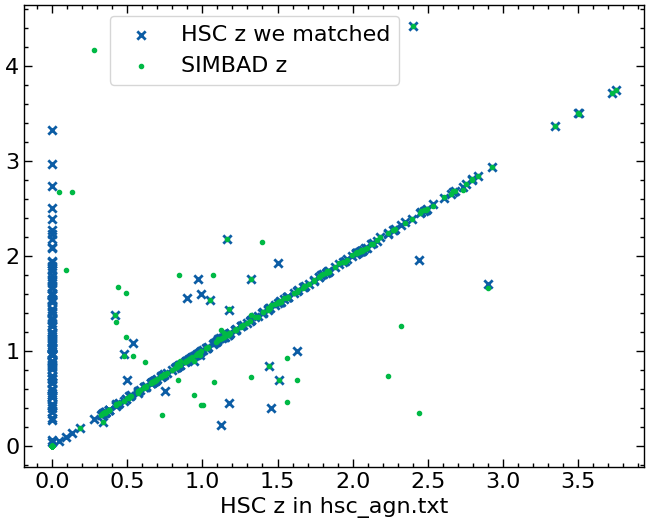

In [73]:
plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'], hsc_sources[idx]['specz_redshift'], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask]['HSC-z'], data_agn_compare[data_hsc_mask]['SIMBAD-z'], 
            marker='.', label='SIMBAD z')
plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

1. Overlapping `.` and `x` indicates that HSC z actually gives the same result as SIMBAD, which means that the HSC-z in `hsc_agn.txt` gives a wrong result. 

2. Single `.` means that HSC is indeed different from SIMBAD, and maybe `HSC` is wrong. We need to further examine where these dots fome from [TODO]. 

3. Single `x` means that the data we matched and the data in `hsc_agn.txt` are different, but `hsc_agn.txt` gives the same result as SIMBAD. 

Ignore 0 values. These are the sources have no SIMBAD spectrum in good quality. 

One possible reason for those off `x` (1. and 3.) is that they used L1 norm instead of cone search to match the catalog. This can be checked by duplication flag [TODO]. 

TODO: check all the sources in HSC and download them

```
specz_flag_primus_dr1
specz_flag_zcosmos_bright_dr3
specz_flag_3dhst_v4_1_5
specz_flag_sdss_dr15 
specz_flag_deimos_2018 (less)
specz_flag_deimos_2018 (less)
specz_flag_lega_c_dr2 (less)
```


In [28]:
data_agn_updated

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.499,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.977,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.573,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.585,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.664,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.999,1,782508,2020ApJ...894...24K
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.474,3,445280,-------------------


In [74]:
hsc_sources

object_id,specz_ra,specz_dec,specz_redshift,specz_duplicationflag,specz_flag_zcosmos_bright_dr3,specz_flag_3dhst_v4_1_5,specz_flag_sdss_dr15,specz_flag_gama_dr3,specz_flag_udsz_dr1,specz_flag_vandels_dr2,specz_flag_c3r2_dr2,specz_flag_vvds_drfinal,specz_flag_deimos_2018,specz_flag_fmos_dr2,specz_flag_lega_c_dr2,specz_flag_primus_dr1,specz_flag_vipers_dr2,specz_flag_wigglez_dr1,specz_flag_deep23_dr4_egs
int64,float64,float64,float64,int64,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5,str5
43158734788123154,150.10261536,2.20605063,1.0276,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349173942,150.18032837,2.21132898,0.65367,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349174975,150.20129395,2.21717215,2.0717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127382,150.13301086,2.22695804,0.9522,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788127788,150.11584473,2.22766662,1.9218,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788135679,150.0609436,2.28366518,0.22569,10,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349178065,150.18655396,2.24057221,0.9281,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158734788131569,150.08352661,2.2660706,1.4717,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
43158597349182175,150.15930176,2.26882362,3.0932,100,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
